# Preprocessing
Sentence preprocessing - for each word POS tag and lemma are created

In [1]:
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN

l = WordNetLemmatizer()
def preprocess_sentence(sentence):
    tagged_sent = nltk.pos_tag(sentence)
    lemma_sent = []
    for tagged_word in tagged_sent:
        lemma_sent.append((tagged_word[0], tagged_word[1], l.lemmatize(tagged_word[0], penn_to_wn(tagged_word[1]))))
    return lemma_sent

NER preprocessing - for each sentence NER tags are generated. NER tags are PERSON, LOCATION and ORGANIZATION.
Brown and Reuters datasets were used. Code below is same for both with one difference - for Reuters dataset sentence had to have at least two named entities for it to be included in data for annotation (function `sentence_has_potential_relation`), while in Brown dataset sentence had to have at least two PERSON entities (function `sentence_has_potential_inter_person_relation`). Latter heuristic was chosen because of lack of inter-person relations in Reuters dataset.

In [ ]:
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tag.stanford import StanfordNERTagger
import random

DATASET = brown #reuters 
filename = 'sentences_brown.txt' #'sentences_reuters.txt'
max_number_sentences = 2500
categories = ['news', 'editorial', 'religion', 'hobbies', 'lore', 'adventure', 'romance', 'humor'] #[]

def sentence_has_potential_relation(sentence):
    NE_number = 0
    in_sequence = False
    for tags in sentence:
        if tags[1] != "O":
            if not in_sequence:
                NE_number += 1
                in_sequence = True
        else:
            in_sequence = False
    if NE_number >= 2:
        return True
    return False

def sentence_has_potential_inter_person_relation(sentence):
    person_number = 0
    in_sequence = False
    for tags in sentence:
        if tags[1] == "PERSON":
            if not in_sequence:
                person_number += 1
                in_sequence = True
        else:
            in_sequence = False
    if person_number >= 2:
        return True
    return False

st = StanfordNERTagger("../stanford-ner-2015-12-09/classifiers/english.all.3class.distsim.crf.ser.gz", 
                      "../stanford-ner-2015-12-09/stanford-ner.jar")

processed_documents = []
file_ids = DATASET.fileids(categories=categories)
document_number = len(file_ids)
num_of_nonNE_sentences = 0
num_of_sentences = 0

sentences_for_write = []

try:
    index = -1
    while num_of_sentences < max_number_sentences:
        sentences = []
        while num_of_sentences < max_number_sentences:
            #index = random.randrange(0,document_number-1,1)
            index = index + 1
            if len(processed_documents) == document_number:
                raise Exception("Ponestalo dokumenata")
            if index in processed_documents:
                continue
            processed_documents.append(index)
            local_sentences = DATASET.sents(file_ids[index])
            num_of_sentences += len(local_sentences)
            sentences.extend(local_sentences)

        tagged_sentences = st.tag_sents(sentences)

        for sentence in tagged_sentences:
            if not sentence_has_potential_inter_person_relation(sentence):
                num_of_sentences -= 1
                continue
            preprocessed_sentence = preprocess_sentence([x[0] for x in sentence])
            preprocessed_sentence = [x+(y[1], ) for x, y in zip(preprocessed_sentence, sentence)]
            sentences_for_write.append(preprocessed_sentence)
except Exception as e:
    print(e)
    
with open(filename, mode='w', encoding='utf-8') as sentences_file:
    for sentence in sentences_for_write:
        for word in sentence:
            sentences_file.write(word[0] + "\t" + word[1] + "\t" + word[2] + "\t" + word[3] + "\n")
        sentences_file.write("\n")

## File format
Each row is in following format:
```
SENTENCE_NUM  WORD_NUM  WORD  POS_TAG  LEMMA  NER_TAG
```
Delimiter is \t. Below is script for adding ordinal numbers to sentences and words.

In [ ]:
with open('sentences_brown.txt', mode='r', encoding='utf-8') as sentences_file, open('sentences_brown_for_annotation.txt', mode='w', encoding='utf-8') as ann_file:
    broj_recenice = 0
    broj_rijeci = 0
    for line in sentences_file:
        if line == "\n":
            broj_recenice += 1
            broj_rijeci = 0
            ann_file.write("\n\n")
            continue
        ann_file.write(str(broj_recenice) + "\t" + str(broj_rijeci) + "\t" + line)
        broj_rijeci += 1

Function for post-annotation creation of POS and lemma tags:

In [2]:
def preprocess_annotated_data(data):
    for instance in data:
        sentence = instance["sentence"]
        preprocessed_sentence = preprocess_sentence([x[0] if x[0] != "" else " " for x in sentence])  #nltk problem s praznim stringom
        instance["sentence"] = [x + (y[1], ) for x, y in zip(preprocessed_sentence, sentence)]
    return data

## Training
Function for loading data from file. Sentence data format is following:
```
{
"sentence": [(WORD, POS_TAG, LEMMA, NER_TAG), ...]
"relations": [(NER1_INDEX, NER2_INDEX, TYPE), ...]
}
```

In [3]:
def load_data(filename):
    relation_definition = False
    data = []
    with open(filename, "r") as f:
        sentence, relations = [], []
        for line in f:
            line = line.strip()
            if line == "":
                if relation_definition:
                    data.append({"sentence": sentence, "relations": relations})
                    sentence, relations = [], []
                    relation_definition = False
                else:
                    relation_definition = True
            elif relation_definition == False:
                line = line.split("\t")
                sentence.append(tuple(line[2:]))
            else:
                line = line.split("\t")
                line[0] = int(line[0])
                line[1] = int(line[1])
                relations.append(tuple(line))
    return data

Code below loads annotated Reuters data, makes preprocessing steps and then loads annotated Brown data:

In [4]:
data = load_data("training_data_1.txt")
data = preprocess_annotated_data(data)
data.extend(load_data("training_data_2.txt"))
print("Number of relations: ", sum([len(x["relations"]) for x in data]), "Number of sentences: ", len(data))

Number of relations:  1902 Number of sentences:  2373


Functions for creating all possible relations in sentence.
- `extract_all_entities` - extracts all entities from sentence in format `(ENTITY_START_INDEX, ENTITY_LENGTH)`
- `generate_entity_pairs` - creates all entity pairs
- `normalize_relations` - by convention all relations are between first and second encountered entity. If some relation is reversed, map it to adequate replacement.
- `create_relations` - creates relations in format `((ENTITY1_START_INDEX, ENTITY1_LENGTH), (ENTITY2_START_INDEX, ENTITY2_LENGTH), RELATION_TYPE`. For entity combinations that are not annotated, relation is `None`.

In [5]:
from itertools import combinations

def extract_all_entities(sentence):
    entities = []
    entity_length = 0
    in_entity = False
    for i in range(len(sentence)):
        word = sentence[i]
        if word[3] != "O":  #ako smo na rijeci koja je oznacena kao dio named entititija
            if in_entity == False:  #ako do sad nismo bili inicijaliziraj sve
                in_entity = True
                entity_index = i
                entity_length = 1
            elif word[3] == sentence[entity_index][3]:  #ako je rijec dio named entitija kojeg brojimo
                entity_length += 1
            else: #ili dio drugog named entitija odmah do prvog
                entities.append((entity_index, entity_length))
                entity_index = i
                entity_length = 1
        elif in_entity == True:  #ako smo izasli iz named entitija
            in_entity = False
            entities.append((entity_index, entity_length))
    return entities

def generate_entity_pairs(entities):
    return [x for x in combinations(entities, 2)]

def normalize_relations(relations, mapping={"parentOrganization": "subOrganization", "containsPlace": "containedInPlace", "memberOf": "member", "children": "parent", "brand": "isBrandOf"}):
    relations = list(relations)
    for i in range(len(relations)):
        if relations[i][0] > relations[i][1]:
            relations[i] = (relations[i][1], relations[i][0], mapping.get(relations[i][2], relations[i][2]))
    return relations

def create_relations(sentence_with_relations):
    entities = extract_all_entities(sentence_with_relations["sentence"])
    annotated_relations = normalize_relations(sentence_with_relations.get("relations", []))
    relations = generate_entity_pairs(entities)
    for i in range(len(relations)):
        relation = relations[i]
        search = [x for x in annotated_relations if x[0] == relation[0][0] and x[1] == relation[1][0]]
        if len(search) > 0:
            relations[i] = relations[i] + (search[0][2],)
        else:
            relations[i] = relations[i] + ("None",)
    return relations

Relation statistics and visualization:

Entity num:  {'ORGANIZATION': 3016, 'PERSON': 2413, 'LOCATION': 1967}
Relation num:  {'parentOrganization': 67, 'spouse': 35, 'subOrganization': 169, 'memberOf': 1, 'relatedTo': 50, 'employee': 334, 'homeLocation': 223, 'isBrandOf': 4, 'member': 9, 'children': 17, 'nationality': 20, 'location': 194, 'containedInPlace': 119, 'containsPlace': 19, 'knows': 159, 'colleague': 404, 'parent': 19, 'brand': 59}
Number of lost positive relations with limit  10  :  363
Remaining positive relations  1529
Number of lost negative relations with limit  10  :  4534
Remaining negative relations  4045


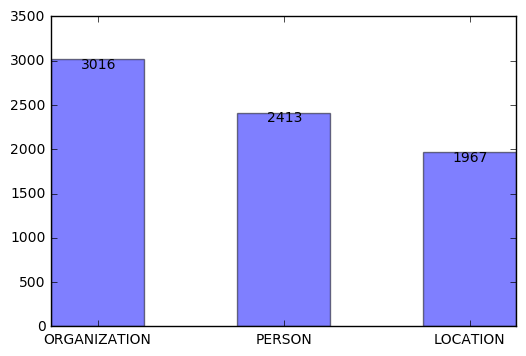

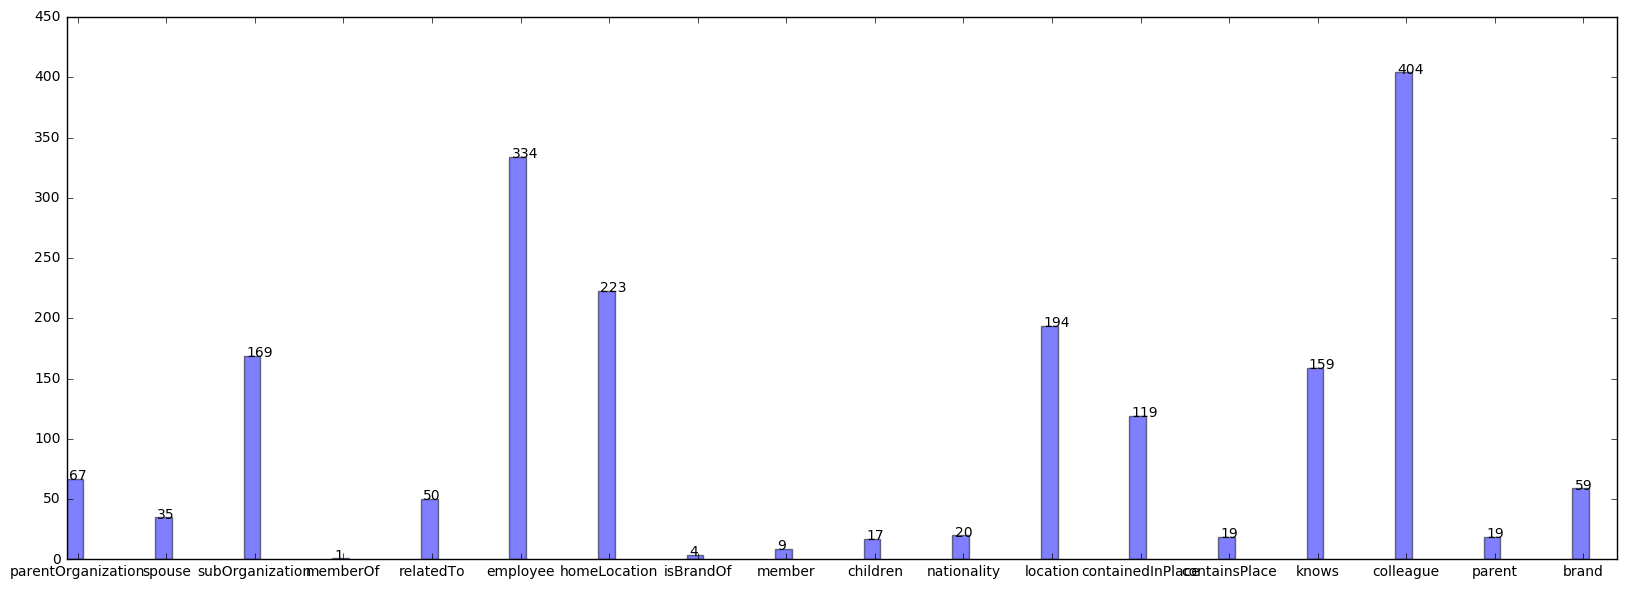

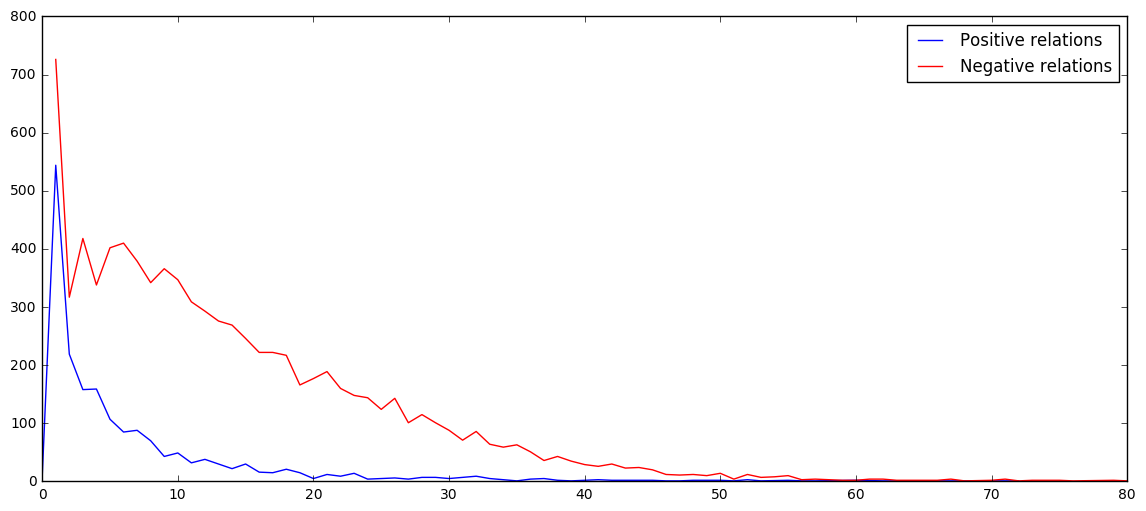

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def extract_entity_count(data):
    entity_count = {}
    for row in data:
        sentence = row["sentence"]
        entities = extract_all_entities(sentence)
        for entity in entities:
            entity_type = sentence[entity[0]][3]
            entity_count[entity_type] = entity_count.get(entity_type, 0) + 1
    return entity_count

entity_count = extract_entity_count(data)
print("Entity num: ", entity_count)
plt.bar([i+1 for i in range(len(entity_count.keys()))], entity_count.values(), 0.5, alpha=0.5)
plt.xticks([i+1.25 for i in range(len(entity_count.keys()))], entity_count.keys())
for i, value in enumerate(entity_count.values()):
    plt.text(i+1.16, value-100, str(value))
    
plt.figure(figsize=(20, 7))

def extract_relation_count(data):
    relation_count = {}
    for row in data:
        relations = normalize_relations(row["relations"])
        for relation in relations:
            relation_type = relation[2]
            relation_count[relation_type] = relation_count.get(relation_type, 0) + 1
    return relation_count

relation_count = extract_relation_count(data)
print("Relation num: ", relation_count)
plt.bar([8*i for i in range(len(relation_count.keys()))], relation_count.values(), 1.5, alpha=0.5)
plt.xticks([8*i+1 for i in range(len(relation_count.keys()))], relation_count.keys())
for i, value in enumerate(relation_count.values()):
    plt.text(8*i+0.2, value-1, str(value))
    
def count_distance(sentences):
    count_pos, count_neg = {}, {}
    for sentence in sentences:
        for relation in create_relations(sentence):
            distance = relation[1][0] - (relation[0][0] + relation[0][1])
            if relation[2] == "None":
                count_neg[distance] = count_neg.get(distance, 0) + 1
                continue
            count_pos[distance] = count_pos.get(distance, 0) + 1
    return count_pos, count_neg
        
def plot_distance(count_pos, count_neg):
    plt.figure(figsize=(14, 6))
    plt.xlim((0,80))
    handle1, = plt.plot([x for x in count_pos.keys()], [x for x in count_pos.values()], label="Positive relations")
    handle2, = plt.plot([x for x in count_neg.keys()], [x for x in count_neg.values()], "r", label="Negative relations")
    plt.legend([handle1, handle2], ["Positive relations", "Negative relations"])
    
count_pos, count_neg = count_distance(data)
plot_distance(count_pos, count_neg)
limit = 10
print("Number of lost positive relations with limit ", limit, " : ", sum([value for key, value in count_pos.items() if key > limit]))
print("Remaining positive relations ", sum([value for key, value in count_pos.items() if key <= limit]))
print("Number of lost negative relations with limit ", limit, " : ", sum([value for key, value in count_neg.items() if key > limit]))
print("Remaining negative relations ", sum([value for key, value in count_neg.items() if key <= limit]))

Feature generation:

In [11]:
def generate_features(sentence_with_relations):
    instances = []
    sentence = sentence_with_relations["sentence"]
    for relation in create_relations(sentence_with_relations):
        instance = {}
        instance["NE1_type"] = sentence[relation[0][0]][3]
        instance["NE1_length"] = relation[0][1]
        instance["NE2_type"] = sentence[relation[1][0]][3]
        instance["NE2_length"] = relation[1][1]
        instance["distance"] = relation[1][0] - (relation[0][0] + relation[0][1])
        instance["word1_type"] = sentence[relation[0][0]][1]
        instance["word2_type"] = sentence[relation[1][0]][1]
        
        generate_sorounding_words_features(instance, relation, sentence)
        generate_NE_overlap_features(instance, relation, sentence)
        generate_NE_position_features(instance, relation, sentence)
        generate_family_relation_features(instance, relation, sentence)
        generate_organization_relation_features(instance, relation, sentence)
        generate_syntax_features(instance, relation, sentence)
        instances.append((instance, relation[2]))
    return instances

def generate_sorounding_words_features(instance, relation, sentence): #employee
    if relation[0][0] - 1 < 0:
        instance["word1_before_type"] = ""
    else:
        instance["word1_before_type"] = sentence[relation[0][0] - 1][1]
    instance["word1_after_type"] = sentence[relation[0][0] + relation[0][1]][1]
    instance["word2_before_type"] = sentence[relation[1][0] - 1][1]
    if relation[1][0] + relation[1][1] >= len(sentence):
        instance["word2_after_type"] = ""
    else:
        instance["word2_after_type"] = sentence[relation[1][0] + relation[1][1]][1]
        
def generate_NE_overlap_features(instance, relation, sentence): #spouse
    NE1, NE2 = set(), set()
    for i in range(relation[0][1]):
        NE1.add(sentence[relation[0][0] + i][2].lower())
    for i in range(relation[1][1]):
        NE2.add(sentence[relation[1][0] + i][2].lower())
    NE_common = NE1.intersection(NE2)
    instance["common_NE_words"] = len(NE_common) > 0
    
def generate_NE_position_features(instance, relation, sentence):
    words_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        words_between.add(sentence[i][3])
    instance["location_between"] = "LOCATION" in words_between
    instance["person_between"] = "PERSON" in words_between
    instance["organization_between"] = "ORGANIZATION" in words_between
    
def generate_family_relation_features(instance, relation, sentence):
    words_between = set()
    family_keywords = {"brother", "sister", "child", "mother", "father", "niece", "nephew", "daughter", "son"}
    spouse_relation_keywords = {"husband", "wife", "romantic", "married", "marriage", "marry", "bride", "groom"}
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        words_between.add(sentence[i][2].lower())
    instance["family_words_len"] = len(words_between.intersection(family_keywords))
    if instance["family_words_len"] > 0:
        instance["family_word"] = words_between.intersection(family_keywords).pop()
    else:
        instance["family_word"] = ""
    instance["spouse_words_len"] = len(words_between.intersection(spouse_relation_keywords))
    if instance["spouse_words_len"] > 0:
        instance["spouse_word"] = words_between.intersection(spouse_relation_keywords).pop()
    else:
        instance["spouse_word"] = ""
        
def generate_organization_relation_features(instance, relation, sentence):
    organization_keywords = {"sell", "dollar", "purchase", 'acquire', 'acquisition', 'affiliate', 'agree', 'agreement', 'arrangement', 'business', 'buy', 'buyer', 'company', 'corp', 'corporation', 'holding', 'investment', 'merge', 'merger', 'negotiation', 'ordinary', 'parent', 'part', 'partners', 'partnership', 'share', 'shareholder', 'specifically', 'subsidiary', 'takeover', 'tender'}
    words_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        words_between.add(sentence[i][2].lower())
    instance["organization_words_len"] = len(words_between.intersection(organization_keywords))
    
def generate_syntax_features(instance, relation, sentence):
    words_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        words_between.add(sentence[i][2])
    instance["contains_separators"] = len({",", ";", ":", "-", "(", ")"}.intersection(words_between)) > 0

Features that were tested but are not improving model accuracy:

In [ ]:
import numpy as np

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

with open("glove.6B.50d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array([x for x in map(float, line.split()[1:])])
           for line in lines}

mv = MeanEmbeddingVectorizer(w2v)

def assume_distant_relations_are_none(instances):
    new_instances = []
    for instance in instances:
        if instance[0]["distance"] <= 10:
            new_instances.append(instance)
    instances = new_instances

In [ ]:
def generate_NE_length_features(instance, relation, sentence):
    for i in range(relation[0][0], relation[0][0] + relation[0][1]):
        instance["word_length1" + str(i)] = len(sentence[i][0])
    for i in range(relation[1][0], relation[1][0] + relation[1][1]):
        instance["word_length2" + str(i)] = len(sentence[i][0])

grammar = r"""
      NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
      CLAUSE: {<NP><VP>}           # Chunk NP, VP
      """
cp = nltk.RegexpParser(grammar, loop=2)
def generate_dependency_features(instance, relation, sentence):
    tree = cp.parse([(x[0], x[1]) for x in sentence])
    node1_position = tree.leaf_treeposition(relation[0][0])
    node2_position = tree.leaf_treeposition(relation[1][0])
    instance["tree_distance"] = len(node1_position) + len(node2_position)
    
def generate_dependency_features2(instance, relation, sentence):
    tree = cp.parse([(x[0], x[1]) for x in sentence])
    node1_position = tree.leaf_treeposition(relation[0][0])
    node2_position = tree.leaf_treeposition(relation[1][0])
    instance["NE1_tree_depth"] = len(node1_position)
    instance["NE2_tree_depth"] = len(node2_position)
    
def generate_dependency_features3(instance, relation, sentence):
    tree = cp.parse([(x[0], x[1]) for x in sentence])
    node1_position = tree.leaf_treeposition(relation[0][0])
    node2_position = tree.leaf_treeposition(relation[1][0])
    path = tree.label()
    node1_position = list(node1_position)
    del node1_position[-1]
    node1_position = tuple(node1_position)
    path_list = []
    while len(node1_position) > 0:
        path_list.append(tree[node1_position].label())
        node1_position = list(node1_position)
        del node1_position[-1]
        node1_position = tuple(node1_position)
    for element in reversed(path_list):
        path = element + "-" + path
    node2_position = list(node2_position)
    del node2_position[-1]
    node2_position = tuple(node2_position)
    path_list = []
    while len(node2_position) > 0:
        path_list.append(tree[node2_position].label())
        node2_position = list(node2_position)
        del node2_position[-1]
        node2_position = tuple(node2_position)
    for element in reversed(path_list):
        path = path + "-" + element
    lista = path.split("-")
    for i in range(len(lista)):
        instance["path" + str(i)] = lista[i]
        
def generate_similarity_features(instance, relation, sentence):
    words_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        words_between.add(sentence[i][2].lower().encode("ascii"))
    distance = np.linalg.norm(mv.transform([list(words_between)])-mv.transform([[b"acquire", b"buy", b"subsidiary", b"purchase", b"pay"]]))
    instance["word_d"] = distance
    
def generate_contains_number_feature(instance, relation, sentence):
    for i in range(len(sentence)):
        try:
            a = int(sentence[i][2])
            instance["has_number"] = True
            return
        except:
            continue
    instance["has_number"] = False
    
def generate_verb_features(instance, relation, sentence):
    verbs_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        if sentence[i][1].startswith("V"):
            verbs_between.add(sentence[i][1])
    instance["verb_number"] = len(verbs_between)
    if len(verbs_between) > 0:
        instance["verb"] = verbs_between.pop()
        
def generate_verb_tense_features(instance, relation, sentence):
    verbs_between = set()
    for i in range(relation[0][0] + relation[0][1], relation[1][0]):
        if sentence[i][1].startswith("V"):
            verbs_between.add(sentence[i][1])
    for verb in verbs_between:
        instance["verb_tense_" + verb[-1]] = True

## Model validation

Nested k-fold cross validation implementation (hyperparameter optimization):

In [13]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from scorer import f1_scorer
import warnings
warnings.filterwarnings('ignore')

_encoder = LabelEncoder()
_vectorizer = DictVectorizer(dtype=float, sparse=True)
_scaler = StandardScaler(with_mean=False)

def nltk_nested_kfold_cv(clf, param_grid, nltk_data, k1=5, k2=3):
    X = _scaler.fit_transform(_vectorizer.fit_transform([x[0] for x in nltk_data]))
    y = _encoder.fit_transform([x[1] for x in nltk_data])
    return nested_kfold_cv(clf, param_grid, X, y, k1, k2)
    
#def f1_scorer(estimator, X, y):  #multithreading hack - function moved from interactive console (this) to scorer module
#    y_predicted = estimator.predict(X)
#    return f1_score(y, y_predicted, average="macro")

def nested_kfold_cv(clf, param_grid, X, y, k1=5, k2=3):
    scores = []
    kfold = StratifiedKFold(k1, shuffle=True)
    for train_index, test_index in kfold.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        #gridCV = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=f1_scorer, cv=k2, n_jobs=4)
        gridCV = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring=f1_scorer, cv=k2, n_jobs=4, verbose=10)
        gridCV.fit(X_train, y_train)
        scores.append((gridCV.score(X_test, y_test), gridCV.best_params_))
    return np.array(scores)

Sentences to features conversion. Some low count classes are replaced with similar classes to improve performance.

In [15]:
instances = []

for sentence in data:
    primjeri = generate_features(sentence)
    instances.extend(primjeri)
    
for i in range(len(instances)):
    if instances[i][1] == "nationality":
        instances[i] = (instances[i][0], "homeLocation")
    if instances[i][1] == "memberOf":
        instances[i] = (instances[i][0], "parentOrganization")
    if instances[i][1] == "member":
        instances[i] = (instances[i][0], "subOrganization")
    if instances[i][1] == "knows":
        instances[i] = (instances[i][0], "colleague")
    if instances[i][1] == "isBrandOf":
        instances[i] = (instances[i][0], "brand")
    
all_classes = set([x[1] for x in instances])
all_classes = list(all_classes)
all_classes.remove("None")
        
print("Number of examples: ", len(instances))

Number of examples:  10471


Hyperparameter optimization for RandomForestClassifier:

In [25]:
print(nltk_nested_kfold_cv(RandomForestClassifier(), {"n_estimators": [x for x in range(1, 305, 10)], "max_depth": [1, 5, 10, 20, 40, 70, 100, None], "max_features": ["sqrt", "log2", None], "min_samples_leaf": [x for x in range(1, 25, 5)], "class_weight": ["balanced"], "n_jobs": [-1]}, instances, 5, 3))

[[0.53899541038782373
  {'max_depth': 100, 'n_jobs': -1, 'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 191}]
 [0.55253560858505935
  {'max_depth': None, 'n_jobs': -1, 'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 191}]
 [0.44201984469347311
  {'max_depth': 40, 'n_jobs': -1, 'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 6, 'n_estimators': 81}]
 [0.58479830524698695
  {'max_depth': None, 'n_jobs': -1, 'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 291}]
 [0.50769781000032321
  {'max_depth': 20, 'n_jobs': -1, 'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 6, 'n_estimators': 121}]]


Hyperparameter optimization for AdaBoostClassifier with DecisionTreeClassifier as base learner:

In [26]:
print(nltk_nested_kfold_cv(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), {"n_estimators": [x for x in range(1, 305, 10)], "base_estimator__max_depth": [1, 5, 10, 20, 40, 70, 100, None], "base_estimator__max_features": ["sqrt", "log2", None], "base_estimator__class_weight": ["balanced"]}, instances, 5, 3))

[[0.54497601939429174
  {'base_estimator__class_weight': 'balanced', 'n_estimators': 291, 'base_estimator__max_depth': 20, 'base_estimator__max_features': None}]
 [0.49316312213372121
  {'base_estimator__class_weight': 'balanced', 'n_estimators': 131, 'base_estimator__max_features': None, 'base_estimator__max_depth': None}]
 [0.52469787541695456
  {'base_estimator__class_weight': 'balanced', 'n_estimators': 271, 'base_estimator__max_features': None, 'base_estimator__max_depth': 20}]
 [0.63566307549535217
  {'base_estimator__class_weight': 'balanced', 'n_estimators': 271, 'base_estimator__max_features': None, 'base_estimator__max_depth': None}]
 [0.61118677498163232
  {'base_estimator__class_weight': 'balanced', 'n_estimators': 181, 'base_estimator__max_depth': 100, 'base_estimator__max_features': None}]]


Hyperparameter optimization for KNeighborsClassifier:

In [45]:
print(nltk_nested_kfold_cv(KNeighborsClassifier(), {"n_neighbors": [x for x in range(1, 150, 10)], "weights": ["uniform", "distance"], "leaf_size": [x for x in range(10, 105, 20)]}, instances, 5, 3))

[[0.42137518207003877
  {'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 10}]
 [0.40980862909140775
  {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 10}]
 [0.34480792018886497
  {'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 10}]
 [0.35191906424414748
  {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 10}]
 [0.39271893385125961
  {'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 10}]]


In [27]:
print(nltk_nested_kfold_cv(SVC(), {"C": [2**x for x in range(-10, 11, 2)], "kernel": ["linear"], "class_weight": ["balanced"]}, instances, 5, 3))

[[0.4464360601226286
  {'kernel': 'linear', 'C': 4, 'class_weight': 'balanced'}]
 [0.42466127621605682
  {'kernel': 'linear', 'C': 1, 'class_weight': 'balanced'}]
 [0.43384798762700816
  {'kernel': 'linear', 'C': 4, 'class_weight': 'balanced'}]
 [0.50503441004572325
  {'kernel': 'linear', 'C': 1024, 'class_weight': 'balanced'}]
 [0.47676639446902869
  {'kernel': 'linear', 'C': 1024, 'class_weight': 'balanced'}]]


In [ ]:
print(nltk_nested_kfold_cv(SVC(), {"C": [2**x for x in range(-5, 6, 2)], "kernel": ["poly"], "degree": [x for x in range(1, 5, 1)], "gamma": [2**x for x in range(-5, 6, 2)], "class_weight": ["balanced"]}, instances, 5, 3))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   54.0s


In [26]:
print(nltk_nested_kfold_cv(SVC(), {"C": [2**x for x in range(-10, 11, 2)], "kernel": ["rbf"], "gamma": [2**x for x in range(-10, 11, 2)], "class_weight": ["balanced"]}, instances, 5, 3))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 12.0min remaining:  1.3min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 13.8min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 10.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 10.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 11.6min remaining:  1.3min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 12.8min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed: 13.1min remaining:  1.5min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 13.7min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:  9.1min remaining:  1.0min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  9.3min finished


[[0.4543954857697467
  {'class_weight': 'balanced', 'kernel': 'rbf', 'gamma': 0.015625, 'C': 256}]
 [0.46165245114902076
  {'class_weight': 'balanced', 'C': 4, 'gamma': 0.015625, 'kernel': 'rbf'}]
 [0.49127769846810282
  {'class_weight': 'balanced', 'gamma': 0.015625, 'kernel': 'rbf', 'C': 256}]
 [0.51079248466026062
  {'class_weight': 'balanced', 'C': 1024, 'gamma': 0.00390625, 'kernel': 'rbf'}]
 [0.5121151118134043
  {'class_weight': 'balanced', 'kernel': 'rbf', 'gamma': 0.00390625, 'C': 16}]]


K-fold cross validation for chosen model and its hyperparameters:

In [12]:
from collections import defaultdict

X = _vectorizer.fit_transform([x[0] for x in instances])
y = _encoder.fit_transform([x[1] for x in instances])
X = _scaler.fit_transform(X)

k = 5
    
kfold = StratifiedKFold(k, shuffle=True)
max_score, best_clf = 0, None
scores = []
class_scores = defaultdict(list)
for train_index, test_index in kfold.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, max_features=None, class_weight="balanced"), n_estimators=180)
    clf.fit(X_train, y_train)
    y_predicted = _encoder.inverse_transform(clf.predict(X_test))
    y_test = _encoder.inverse_transform(y_test)
    score = f1_score(y_test, y_predicted, average="macro")
    scores.append(score)
    if score > max_score:
        max_score = score
        best_clf = clf
    for c in all_classes:
        class_scores[c].append(f1_score(y_test, y_predicted, average="macro", labels=[c]))

print("Total F1 score: ", sum(scores)/k, "\n")
print("F1 scores per class:")
for key, value in class_scores.items():
    print(key, sum(np.array(value))/k)

Total F1 score:  0.564338617389 

F1 scores per class:
containedInPlace 0.649526994744
children 0.769523809524
containsPlace 0.18
location 0.607506933223
subOrganization 0.316086575849
homeLocation 0.718265209571
parentOrganization 0.190588235294
spouse 0.595555555556
colleague 0.650660161764
relatedTo 0.271196581197
parent 0.564761904762
brand 0.75315942029
employee 0.693377086562


Saving the final model for usage:

In [308]:
import pickle

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, max_features=None, class_weight="balanced"), n_estimators=180)
clf.fit(X, y)
pickle.dump((clf, _vectorizer, _encoder, _scaler), open("model.data", "wb"))